# analyze `allblocks.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks.db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Tobalaba" chain of the Energy Web Foundation (https://tobalaba.etherscan.com).

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [TPS diagram whole chain](#TPSall)
* [maximum txcount block](#maxTPS)


Always 4 diagrams each:

* [peak txcount block - all 4 diagrams in one](#maxTPSall4)
* [whole chain - all 4 diagrams in one](#WholeChainAll4)
* [other timespans with high TPS, incl zooming in](#otherAll4) (two ranges)

my own `chainhammer` experiment:

* [1000 TPS shot at the node as fast as possible, see chainhammer/tobalaba.md](#chainhammer1000)



<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

DBFILE="allblocks.db"
print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.3
matplotlib version 2.2.2

Reading blocks table from allblocks.db


In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 4429200 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 4429199)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 4429200


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 4429199.


In [ ]:
# inspect the missing ranges
#print (DB_query("SELECT blocknumber FROM blocks WHERE blocknumber>=96 AND blocknumber<=101 ORDER BY blocknumber", conn) )
#print (DB_query("SELECT blocknumber FROM blocks WHERE blocknumber>=972 AND blocknumber<=1001 ORDER BY blocknumber", conn) )
#print (DB_query("SELECT blocknumber FROM blocks WHERE blocknumber>=9739 AND blocknumber<=10001 ORDER BY blocknumber", conn) )

<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 118576
txcount_max 1179
txcount_av 0.7582807278966857
txcount_sum 3358577
blocks_nonempty_count 1980509
av tx per nonempty blocks =  1.6958150657230036


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)

In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
1210825,1210825,1513160489,118576,63084419,80000000,1179,2.0,589.500000,133.777778,89.071429,60.931034,3.154221e+07,7.137348e+06,4.746350e+06,4.000000e+07,2.666667e+07,2.857143e+07
1211545,1211545,1513162847,55851,29377134,80000000,555,3.0,185.000000,73.777778,57.470588,44.343750,9.792378e+06,4.697972e+06,3.445300e+06,2.666667e+07,2.665798e+07,2.352481e+07
1210819,1210819,1513160471,51078,25969013,80000000,508,3.0,169.333333,63.750000,30.705882,37.281250,8.656338e+06,3.255895e+06,2.037463e+06,2.666667e+07,2.999022e+07,2.352481e+07
1211551,1211551,1513162865,32197,16552533,80000000,318,2.0,159.000000,59.555556,43.642857,45.466667,8.276266e+06,3.163174e+06,2.326110e+06,4.000000e+07,2.666667e+07,2.857143e+07
1210913,1210913,1513160778,47919,23707372,80000000,476,3.0,158.666667,58.111111,41.266667,38.677419,7.902457e+06,2.912316e+06,2.094251e+06,2.666667e+07,2.666667e+07,2.666667e+07
1210847,1210847,1513160561,28365,14566790,80000000,277,2.0,138.500000,33.444444,24.214286,18.533333,7.283395e+06,1.771435e+06,1.272416e+06,4.000000e+07,2.666667e+07,2.857143e+07
1211511,1211511,1513162736,28095,14552419,79999923,275,2.0,137.500000,37.666667,30.944444,27.636364,7.276210e+06,2.893448e+06,2.105098e+06,3.999996e+07,2.665798e+07,2.221788e+07
1210814,1210814,1513160454,40170,20586884,80000000,398,3.0,132.666667,55.500000,44.733333,26.483871,6.862295e+06,2.880157e+06,2.337651e+06,2.666667e+07,2.400000e+07,2.666667e+07
1211522,1211522,1513162772,32667,16566672,79999923,322,3.0,107.333333,45.111111,44.647059,40.212121,5.522224e+06,3.178886e+06,2.803253e+06,2.666664e+07,2.665798e+07,2.352481e+07
1211527,1211527,1513162787,17682,9361156,80000000,172,2.0,86.000000,37.625000,36.866667,41.000000,4.680578e+06,1.956197e+06,1.884733e+06,4.000000e+07,3.000000e+07,2.666667e+07


In [ ]:
# peak TPS over three blocks

df.sort_values(by=['TPS_3blks'], ascending=False)[0:5]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
1210825,1210825,1513160489,118576,63084419,80000000,1179,2.0,589.50,133.777778,89.071429,60.931034,31542209.5,7.137348e+06,4.746350e+06,4.000000e+07,2.666667e+07,2.857143e+07
1210826,1210826,1513160495,580,0,80000000,0,6.0,0.00,98.666667,73.352941,55.187500,0.0,5.282415e+06,3.908759e+06,1.333333e+07,2.000000e+07,2.352941e+07
1210827,1210827,1513160499,743,8000000,80000000,1,4.0,0.25,98.333333,63.421053,53.545455,2000000.0,5.923702e+06,3.801902e+06,2.000000e+07,2.000000e+07,2.105263e+07
1211545,1211545,1513162847,55851,29377134,80000000,555,3.0,185.00,73.777778,57.470588,44.343750,9792378.0,4.697972e+06,3.445300e+06,2.666667e+07,2.665798e+07,2.352481e+07
1211546,1211546,1513162851,7889,3918450,80000000,73,4.0,18.25,73.600000,47.062500,44.121212,979612.5,3.820020e+06,2.939790e+06,2.000000e+07,2.399999e+07,2.499511e+07


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
1210825,1210825,1513160489,118576,63084419,80000000,1179,2.0,589.500000,133.777778,89.071429,60.931034,3.154221e+07,7.137348e+06,4.746350e+06,4.000000e+07,2.666667e+07,2.857143e+07
1210826,1210826,1513160495,580,0,80000000,0,6.0,0.000000,98.666667,73.352941,55.187500,0.000000e+00,5.282415e+06,3.908759e+06,1.333333e+07,2.000000e+07,2.352941e+07
1210827,1210827,1513160499,743,8000000,80000000,1,4.0,0.250000,98.333333,63.421053,53.545455,2.000000e+06,5.923702e+06,3.801902e+06,2.000000e+07,2.000000e+07,2.105263e+07
1210828,1210828,1513160501,564,0,79921876,0,2.0,0.000000,0.083333,65.833333,53.484848,0.000000e+00,6.666667e+05,3.966055e+06,3.996094e+07,1.999349e+07,2.221788e+07
1211551,1211551,1513162865,32197,16552533,80000000,318,2.0,159.000000,59.555556,43.642857,45.466667,8.276266e+06,3.163174e+06,2.326110e+06,4.000000e+07,2.666667e+07,2.857143e+07
1211553,1211553,1513162875,6366,11166037,80000000,57,3.0,19.000000,42.583333,38.368421,45.294118,3.722012e+06,2.884097e+06,2.448695e+06,2.666667e+07,2.000000e+07,2.105263e+07
1211545,1211545,1513162847,55851,29377134,80000000,555,3.0,185.000000,73.777778,57.470588,44.343750,9.792378e+06,4.697972e+06,3.445300e+06,2.666667e+07,2.665798e+07,2.352481e+07
1211546,1211546,1513162851,7889,3918450,80000000,73,4.0,18.250000,73.600000,47.062500,44.121212,9.796125e+05,3.820020e+06,2.939790e+06,2.000000e+07,2.399999e+07,2.499511e+07
1211547,1211547,1513162853,2982,1460273,80000000,24,2.0,12.000000,72.444444,50.733333,43.969697,7.301365e+05,3.861762e+06,3.177365e+06,4.000000e+07,2.666667e+07,2.666145e+07
1211552,1211552,1513162872,14231,6890599,80000000,136,7.0,19.428571,51.916667,38.052632,43.647059,9.843713e+05,2.709133e+06,1.999782e+06,1.142857e+07,2.000000e+07,2.105263e+07


<a id='TPSall'>TPS whole chain</a>
## TPS, the whole chain

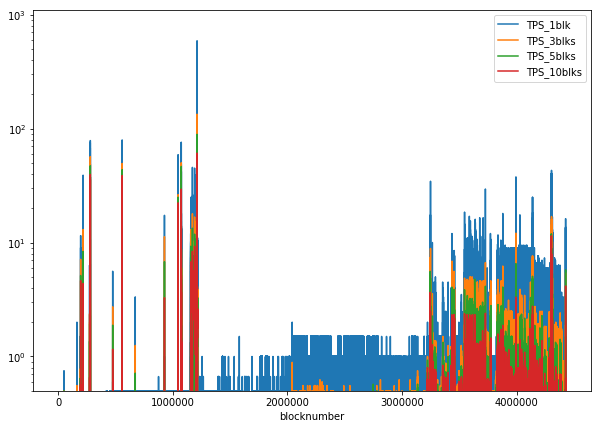

In [ ]:
# show TPS over whole dataset:
cols = ['blocknumber', 'TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
ax=df[cols].plot(x='blocknumber', figsize=(10,7), logy=True)
ax.set_ylim(bottom=0.5)
ax.get_figure().savefig("img/TPS_allBlocks.png")

<a id='maxTPS'>peak txcount block</a>
## around block 1,210,825 (peak txcount=1179)

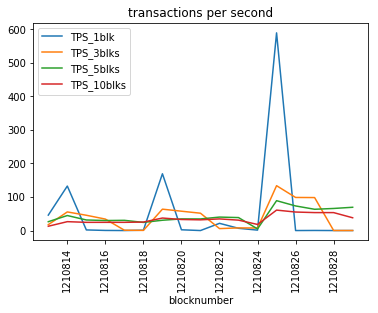

In [ ]:
# details around the peak at block 1210825
# https://tobalaba.etherscan.com/block/1210825

# TPS

def diag_TPS(df, blockFrom, blockTo):
    ax=df[['blocknumber', 'TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']][blockFrom:blockTo].plot(x='blocknumber', rot=90)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_title("transactions per second")
    if blockTo - blockFrom > 20:
        ax.locator_params(nbins=10, axis='x')
    # ax.get_figure().savefig("img/TPS_blks%d-%d.png" % (blockFrom,blockTo))
    
diag_TPS(df, 1210813, 1210830)

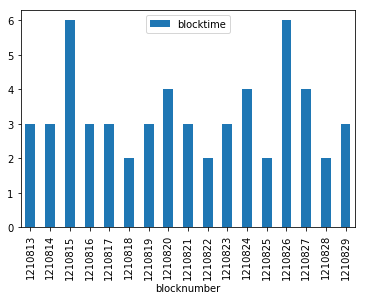

In [ ]:
# blocktime

ax=df[['blocknumber', 'blocktime']][1210813:1210830].plot(x='blocknumber', kind='bar')
# ax.get_figure().savefig("img/blocktime_blks1210813-1210830.png")

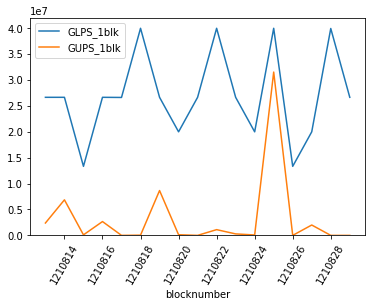

In [ ]:
# gasUsed, gasLimit

ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][1210813:1210830].plot(x='blocknumber', rot=60) #, logy=True)
ax.set_ylim(bottom=1)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ax.get_yaxis().get_major_formatter().set_scientific(False)
# ax.get_figure().savefig("img/gasUsed-gasLimit_blks1210813-1210830.png")

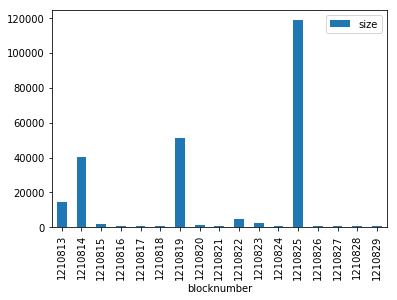

In [ ]:
# blocksize in bytes

ax=df[['blocknumber', 'size']][1210813:1210830].plot(x='blocknumber', rot=90, kind='bar')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

# ax.get_figure().savefig("img/blocksize_blks1210813-1210830.png")

<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=5.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS
    cols=['blocknumber', 'TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1])
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=10, axis='x')
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=10, axis='x')
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/tps-bt-bs-gas_blks%d-%d.png" % (blockFrom,blockTo))


<a id='maxTPSall4'>peak txcount block - all 4 diagrams in one</a>

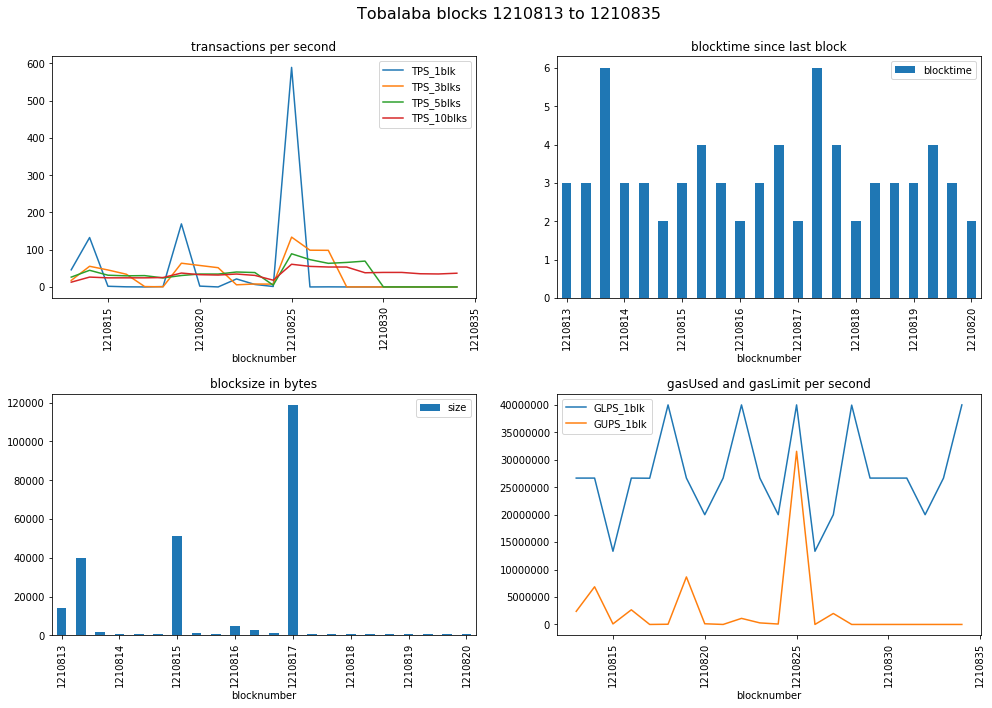

In [ ]:
# all diagrams, around the peak-TPS block 1210825

diagrams(df, 1210813, 1210835, "Tobalaba", gas_logy=False)

<a id='WholeChainAll4'>whole chain - all 4 diagrams in one</a>
## the whole chain

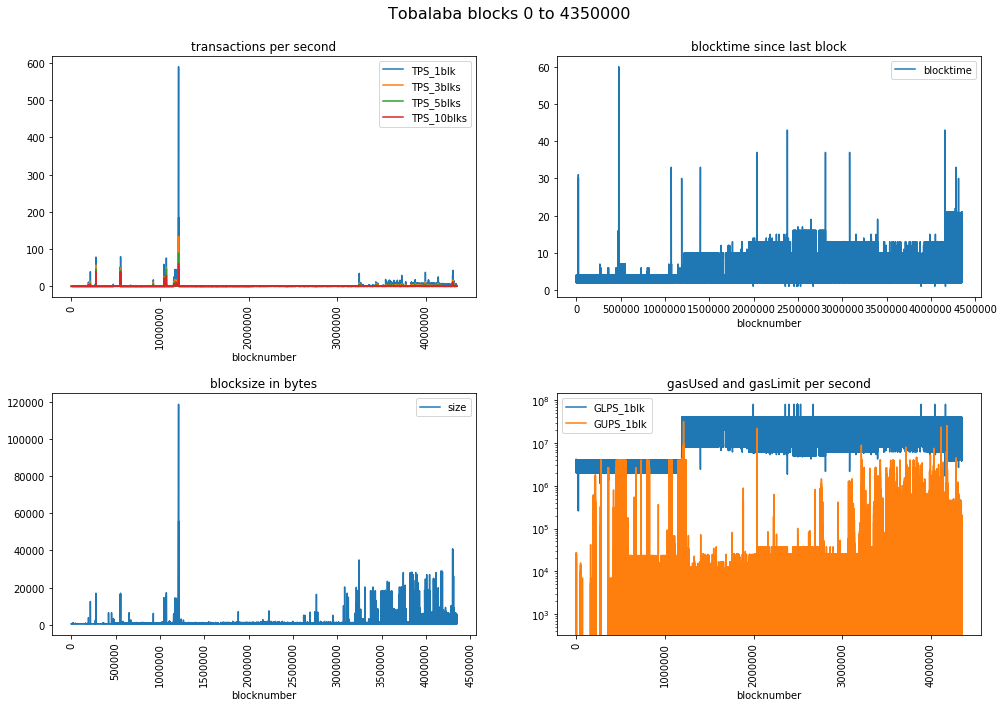

In [ ]:
# the whole range of blocks

diagrams(df, 0, 4350000, "Tobalaba")

<a id='otherAll4'>other timespans with high TPS, incl zooming in</a>
## longer phases with relatively high TPS

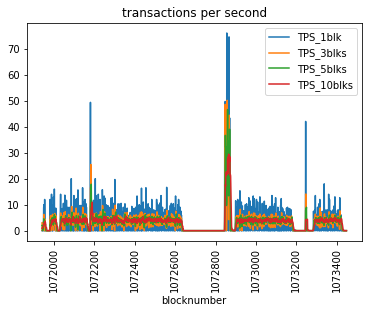

In [ ]:
diag_TPS(df, 1071940, 1073450)

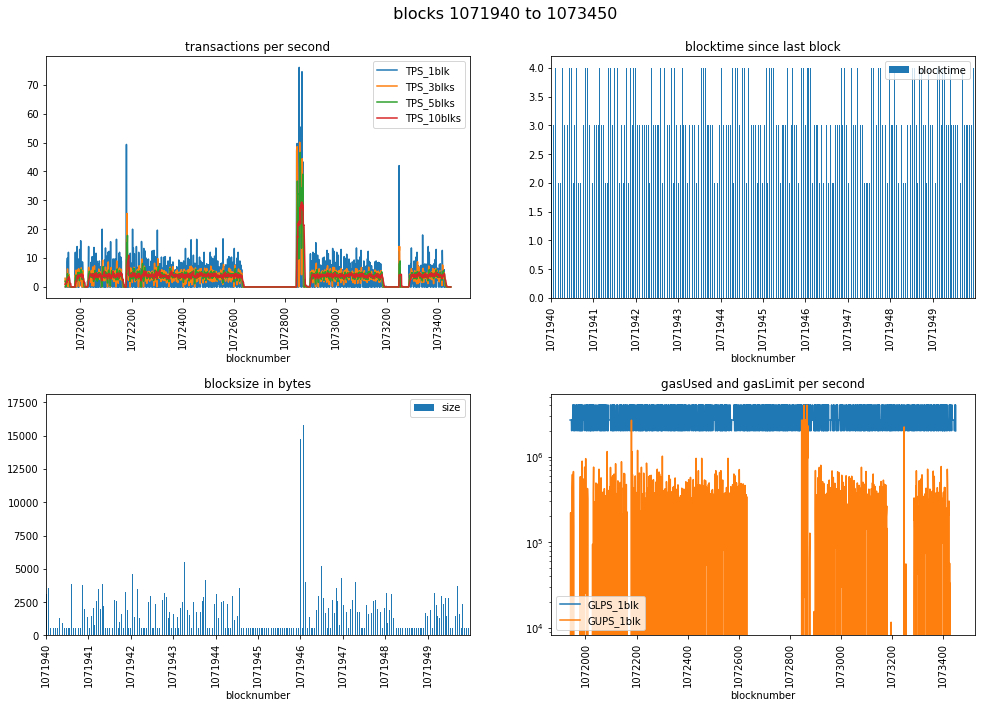

In [ ]:
# all diagrams

diagrams(df, 1071940, 1073450)

## zooming in

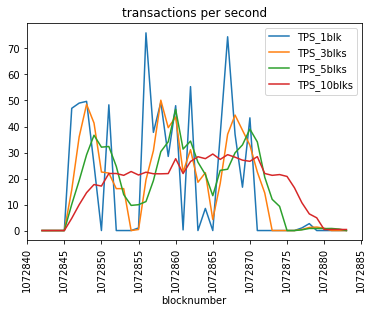

In [ ]:
diag_TPS(df, 1072842, 1072884)

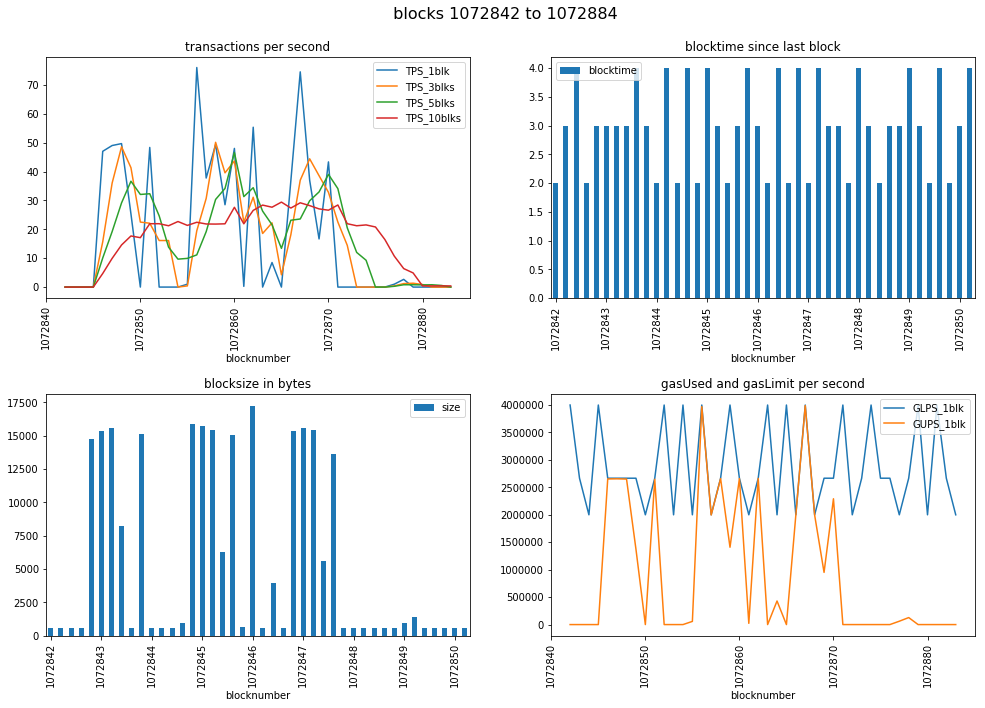

In [ ]:
# all diagrams

diagrams(df, 1072842, 1072884, gas_logy=False)

## area with consistently high TPS, towards the recent end of the chain

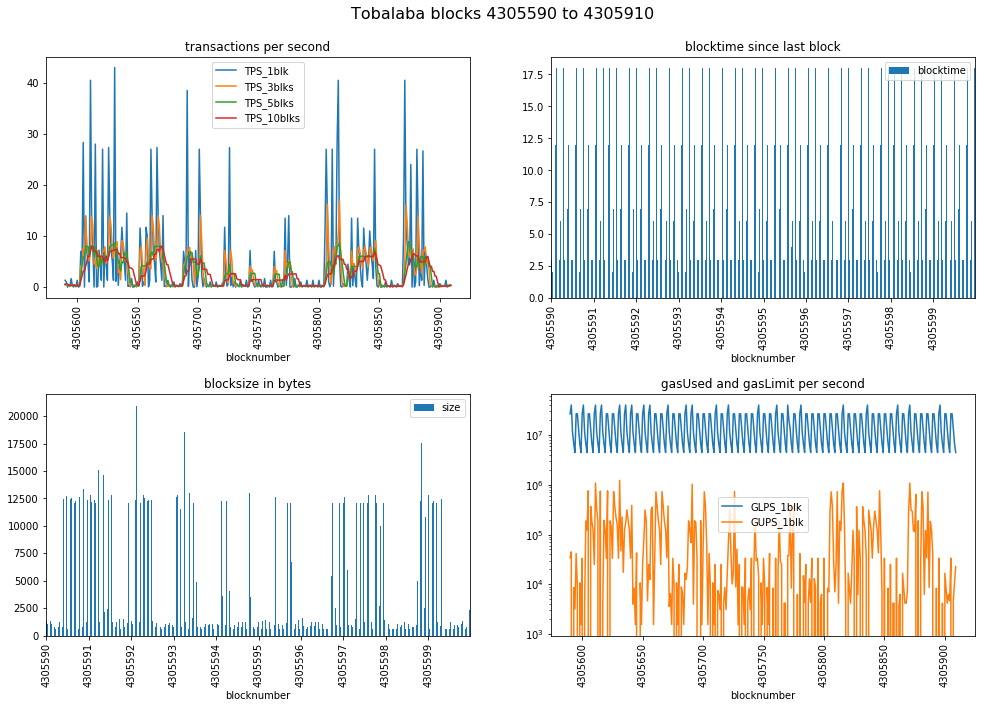

In [ ]:
diagrams(df, 4305590, 4305910, "Tobalaba")

<a id='chainhammer1000'>1000 TPS shot at the node as fast as possible, see chainhammer/tobalaba.md</a>
# my own experiment: 
## 1000 transactions submitted with `chainhammer` 

Between blocks 4428720 and 4428740, I have committed 1000 transactions, for details see

https://github.com/drandreaskrueger/chainhammer/blob/master/tobalaba.md
    
The transactions per second are surprisingly low:

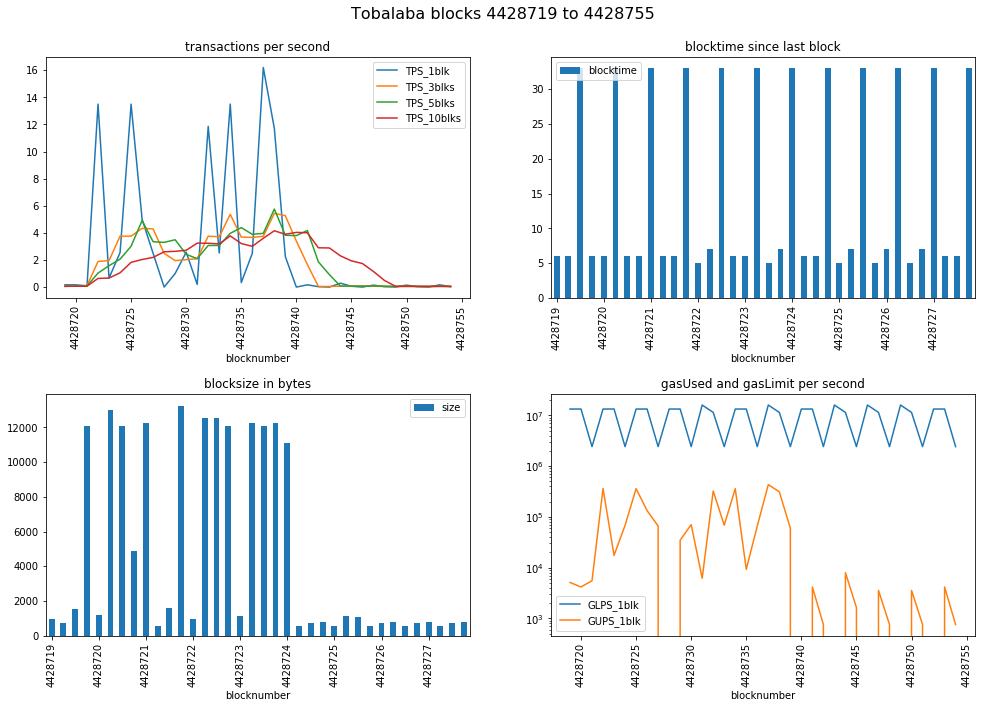

In [ ]:
diagrams(df, 4428719, 4428755, "Tobalaba")